In [ ]:
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LeakyReLU, Input, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2
from livelossplot import PlotLossesKeras

from glob import glob
from os.path import join

from scipy.stats import zscore
from functools import reduce

In [ ]:
weather_path = join('..','data','weather','precip_temp.csv')
weather_df = pd.read_csv(weather_path)
clients_path = join('..','data','wifi','**','Clients per day.csv')
clients_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(clients_path),reverse=True)), ignore_index=True)
sessions_path = join('..','data','wifi','**','Number of sessions over time.csv')
sessions_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(sessions_path), reverse=True)), ignore_index=True)
usage_path = join('..','data','wifi','**','Usage over time.csv')
usage_df = pd.concat(map(lambda csv: pd.read_csv(csv, parse_dates=[0]),
                sorted(glob(usage_path), reverse=True)), ignore_index=True)
# Interpolate zeros in usage and sessions data
usage_df.loc[usage_df['Total (B)'] == 0, 'Total (B)'] = np.NaN
usage_df['Total (B)'] = usage_df['Total (B)'].interpolate()
# Remove implausibly small values
usage_df['filtered Total (B)'] = usage_df['Total (B)']
usage_df.loc[usage_df['filtered Total (B)'] < 1000, 'filtered Total (B)'] = np.NaN
usage_df['filtered Total (B)'] = usage_df['filtered Total (B)'].interpolate()

# Remove redundant 06-30-17 data point
usage_df.drop(0, inplace=True)
sessions_df.loc[sessions_df['# Sessions'] == 0, '# Sessions'] = np.NaN
sessions_df['# Sessions'] = sessions_df['# Sessions'].interpolate()

In [ ]:
# Add day of the week as a one-hot
weekday_labels = []
for d in range(7):
    label = 'weekday-%i' % d
    weekday_labels.append(label)
    clients_df[label] = [int(dt.weekday()==d) for dt in clients_df['Time']]
    
# Put wifi date in the same format as it is in the weather data
clients_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in clients_df['Time']]
clients_df['Year %'] = [dt.timetuple()[7] / 365 for dt in clients_df['Time']]
sessions_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in sessions_df['Time']]
usage_df['Date'] = [dt.strftime('%Y-%m-%d') for dt in usage_df['Time']]
usage_df['Hour'] = [dt.hour for dt in usage_df['Time']]


all_data = clients_df.merge(weather_df, left_on='Date', right_on='DATE') \
    .merge(sessions_df, left_on='Date', right_on='Date')

# Put 4-hour chunks together into rows by day
usage_labels = set()
val_usage_labels = set()
for index, row in usage_df.iterrows():
    total_label = 'total-%i' % row['Hour']
    val_label = 'val-total-%i' % row['Hour']
    all_data.loc[all_data['DATE'] == row['Date'], total_label] \
        = row['filtered Total (B)']
    all_data.loc[all_data['DATE'] == row['Date'], val_label] \
        = row['Total (B)']
    usage_labels.add(total_label)
    val_usage_labels.add(val_label)
usage_labels = list(usage_labels)
val_usage_labels = list(val_usage_labels)

# Normalize weather data
all_data[['TMIN','TMAX']] -= (all_data[['TMIN', 'TMAX']].sum().sum() \
                              / all_data[['TMIN', 'TMAX']].size)
all_data[['TMIN','TMAX']] /= (all_data[['TMIN', 'TMAX']].abs().sum().sum() \
                              / all_data[['TMIN', 'TMAX']].size)
all_data['PRCP'] = zscore(all_data['PRCP'])

In [ ]:
holdout_data = all_data.sample(frac=0.05)
training_data = all_data.drop(holdout_data.index)

# Separate inputs into categories for encoding
weather_x = training_data[['PRCP', 'TMAX', 'TMIN']].values
day_x = training_data[weekday_labels].values
date_x = training_data[['Year %']]

usage_y = training_data[usage_labels].values
clients_y = training_data[['# Clients']].values
sessions_y = training_data[['# Sessions']].values

validation_data = ([holdout_data[['PRCP','TMAX','TMIN']].values,
                    holdout_data[weekday_labels].values,
                    holdout_data[['Year %']].values],
                   # the next line *should* use val_usage_labels, but it causes loss to explode
                   [holdout_data[usage_labels].values,
                    holdout_data[['# Clients']].values,
                    holdout_data[['# Sessions']].values])

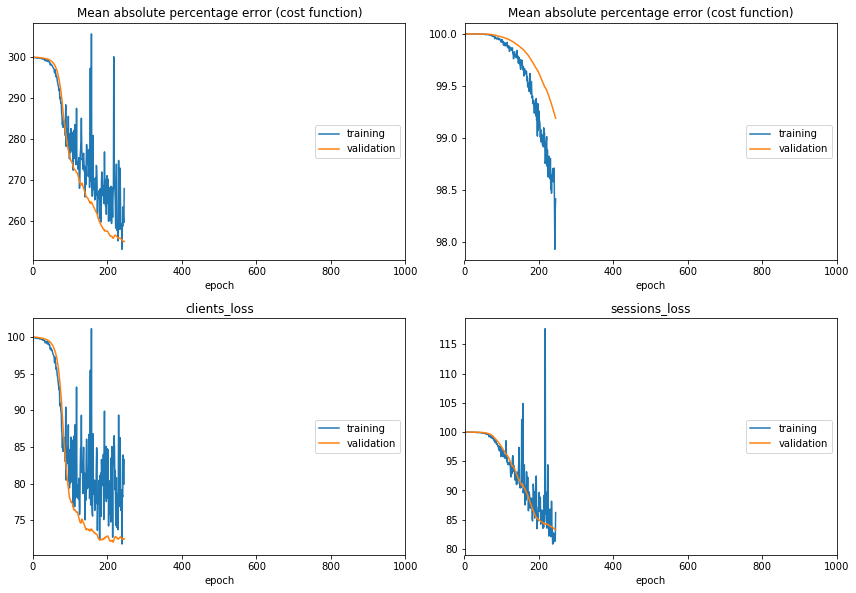

335/335 [==============================] - 0s 1ms/step - loss: 267.9139 - usage_loss: 98.4118 - clients_loss: 83.2785 - sessions_loss: 86.2235 - val_loss: 254.9844 - val_usage_loss: 99.1893 - val_clients_loss: 72.4864 - val_sessions_loss: 83.3087
Epoch 246/1000
224/335 [===================>..........] - ETA: 0s - loss: 249.3810 - usage_loss: 98.3219 - clients_loss: 71.9590 - sessions_loss: 79.1001

In [ ]:
epochs = 1000
reg = None # l1_l2(0.01,0.02)

stack_layers = lambda layers: reduce(lambda stack, e: e(stack), layers)

weather_layers = \
  [Input((3,), name='weather')] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(4, activation='relu',kernel_regularizer=reg)]

weather_out = stack_layers(weather_layers)

day_layers = \
  [Input((7,), name='day')] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)]

day_out = stack_layers(day_layers)

date_layers = \
  [Input((1,), name='date')] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(5, activation='relu',kernel_regularizer=reg)]

date_out = stack_layers(date_layers)

main_layers = \
  [concatenate([weather_out, day_out, date_out])] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(20, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] 

main_out = stack_layers(main_layers)

usage_layers = \
  [main_out] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(6, activation='relu',kernel_regularizer=reg, name='usage')]

usage_out=stack_layers(usage_layers)

clients_layers = \
  [main_out] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(1, activation='relu',kernel_regularizer=reg, name='clients')]

clients_out = stack_layers(clients_layers)

sessions_layers = \
  [main_out] \
+ [Dense(15, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(10, activation='relu',kernel_regularizer=reg)] \
+ [Dropout(0.5)] \
+ [Dense(1, activation='relu',kernel_regularizer=reg, name='sessions')]

sessions_out = stack_layers(sessions_layers)

model = Model(inputs=[weather_layers[0], day_layers[0], date_layers[0]], outputs=[usage_out,clients_out,sessions_out])
model.compile(loss='mean_absolute_percentage_error',
              optimizer=Adam(0.0001))

model.summary()

early_stopping = EarlyStopping(patience=50, verbose=1)
history = model.fit([weather_x,day_x,date_x], [usage_y,clients_y,sessions_y],
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_data,
                    callbacks=[early_stopping, PlotLossesKeras()],
                    batch_size=32)
model_path = join('..','models','model.h5')
model.save(model_path)